In [12]:
1+10

11

In [14]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.lines import Line2D

# Create output directories
os.makedirs('segmentation_masks/exudates', exist_ok=True)
os.makedirs('fovea_masks', exist_ok=True)
os.makedirs('fovea_on_exudate_masks', exist_ok=True)
os.makedirs('distance_line_images', exist_ok=True)
os.makedirs('example_plots', exist_ok=True)

# Load sample image for segmentation
test_img_path = "A. Segmentation/1. Original Images/b. Testing Set/IDRiD_55.jpg"
img = cv2.imread(test_img_path)
if img is None:
    print(f"Error: Could not load {test_img_path}")
    exit()
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

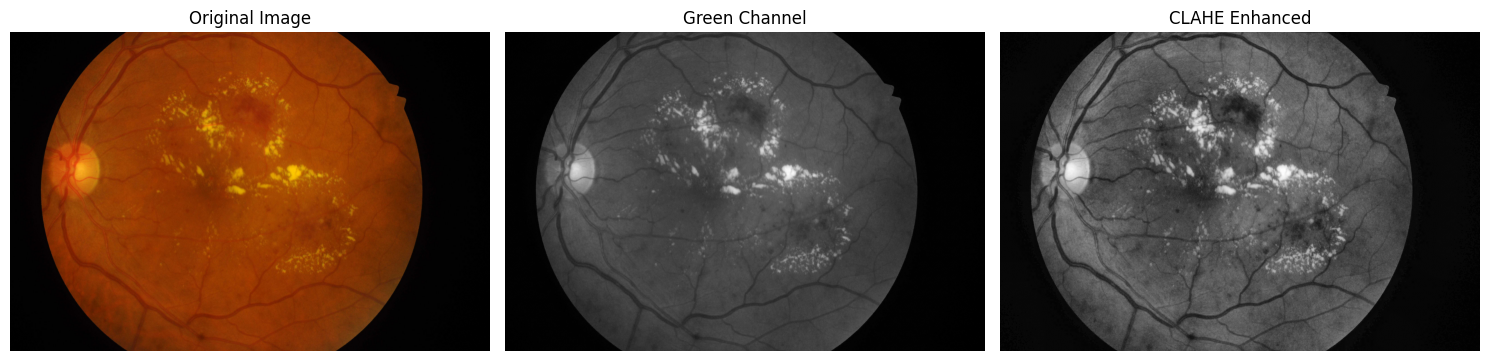

In [15]:
# Extract green channel
green = img_rgb[:, :, 1]

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_green = clahe.apply(green)

# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(green, cmap='gray')
plt.title("Green Channel")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(enhanced_green, cmap='gray')
plt.title("CLAHE Enhanced")
plt.axis('off')

plt.tight_layout()
plt.savefig('example_plots/green_and_clahe.png')
plt.show()

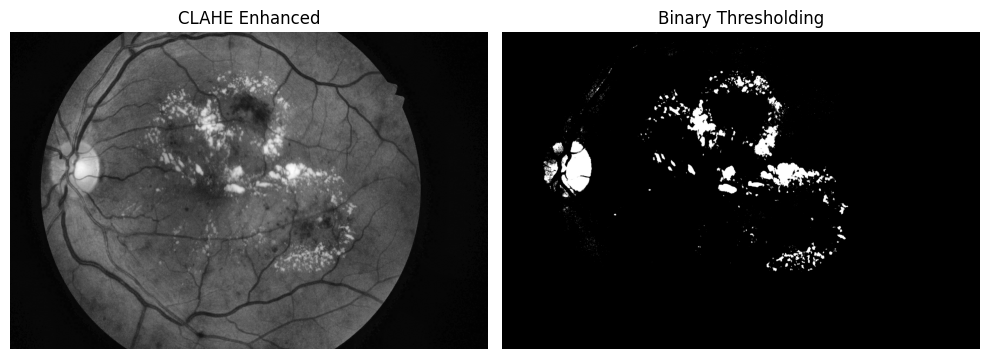

In [16]:
# Thresholding
intensity_thresh = int(np.percentile(enhanced_green, 97))
_, binary = cv2.threshold(enhanced_green, intensity_thresh, 255, cv2.THRESH_BINARY)

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(enhanced_green, cmap='gray')
plt.title("CLAHE Enhanced")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binary Thresholding")
plt.axis('off')

plt.tight_layout()
plt.savefig('example_plots/binary_threshold.png')
plt.show()

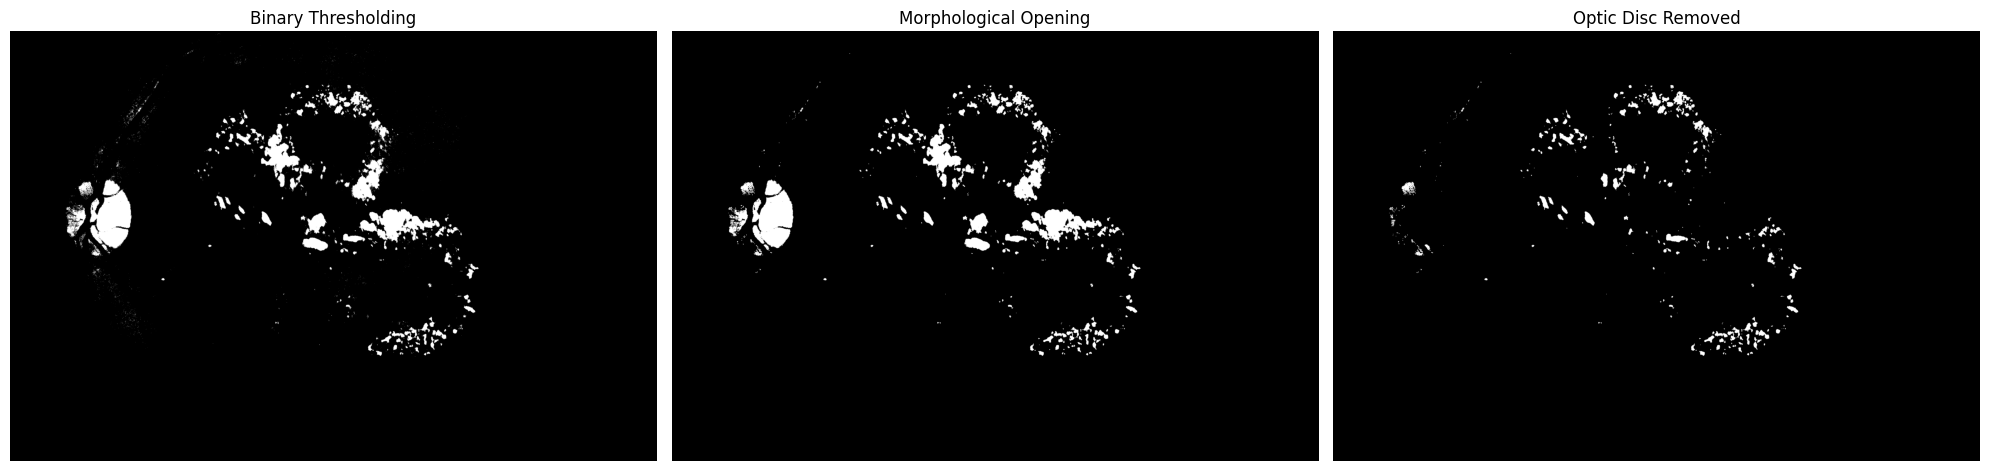

In [17]:
# Morphological opening
kernel = np.ones((3, 3), np.uint8)
cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Optic disc removal
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_no_disc = np.zeros_like(cleaned)
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 5000:
        cv2.drawContours(mask_no_disc, [cnt], -1, 255, thickness=cv2.FILLED)
cleaned_no_disc = cv2.bitwise_and(cleaned, cv2.bitwise_not(mask_no_disc))

# Hard exudate filtering
contours, _ = cv2.findContours(cleaned_no_disc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
refined_mask = np.zeros_like(cleaned)
exudates = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        continue
    circularity = 4 * np.pi * (area / (perimeter ** 2))
    solidity = area / cv2.contourArea(cv2.convexHull(cnt))
    if 10 <= area <= 3000 and 0.3 <= circularity <= 2 and solidity > 0.5:
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            r, g, b = img_rgb[cy, cx]
            if g > 100 and r > 70 and b < 150 and g > b and r > b:
                cv2.drawContours(refined_mask, [cnt], -1, 255, thickness=cv2.FILLED)
                exudates.append(cnt)
refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel)

# Visualize
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(binary, cmap='gray')
plt.title("Binary Thresholding")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cleaned, cmap='gray')
plt.title("Morphological Opening")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cleaned_no_disc, cmap='gray')
plt.title("Optic Disc Removed")
plt.axis('off')

plt.tight_layout()
plt.savefig('example_plots/morphological_to_exudates.png')
plt.show()

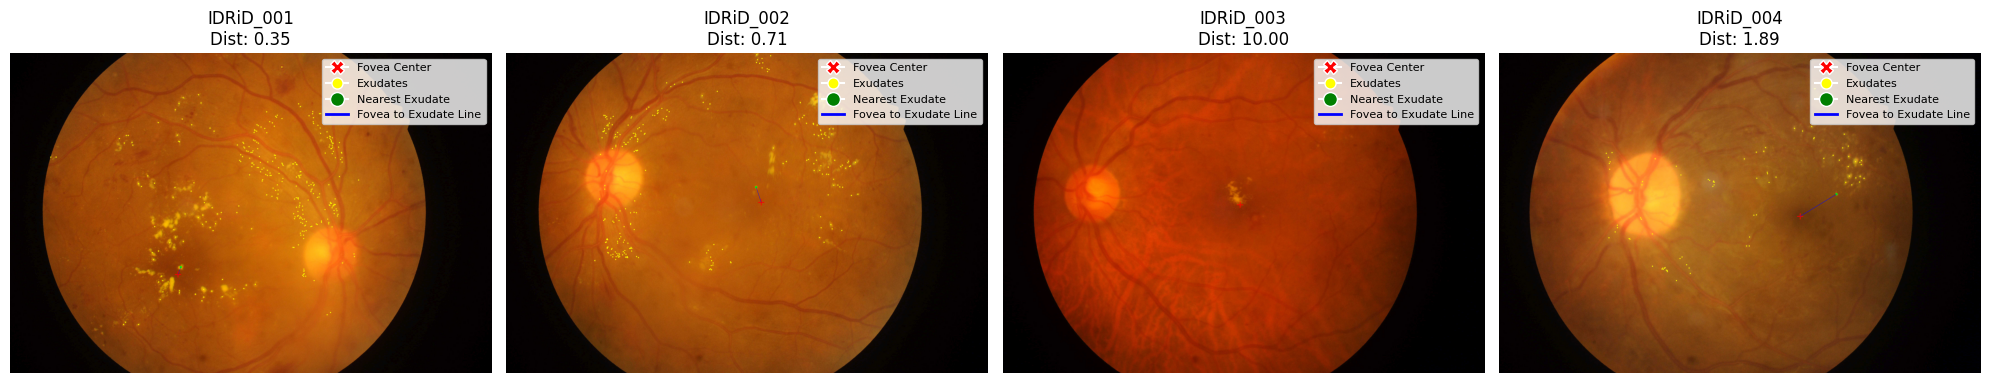

In [18]:
# Load sample data for fovea-to-exudate visualization
train_fovea = pd.read_csv('C. Localization/2. Groundtruths/2. Fovea Center Location/IDRiD_Fovea_Center_Training Set_Markups.csv',
                          usecols=['Image No', 'X- Coordinate', 'Y - Coordinate'])
train_fovea.columns = ['image_name', 'fovea_x', 'fovea_y']
sample_data = train_fovea.head(4)

def visualize_exudates_and_distance(img, fovea_x, fovea_y, exudates, image_name, save_path, DD=200):
    img_copy = img.copy()
    min_distance = 10.0
    nearest_exudate_centroid = None
    
    for cnt in exudates:
        M = cv2.moments(cnt)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            cv2.circle(img_copy, (cx, cy), 5, (0, 255, 255), -1)
            dist = np.sqrt((cx - fovea_x)**2 + (cy - fovea_y)**2) / DD
            if dist < min_distance:
                min_distance = dist
                nearest_exudate_centroid = (cx, cy)
    
    cv2.drawMarker(img_copy, (int(fovea_x), int(fovea_y)), (0, 0, 255), 
                   markerType=cv2.MARKER_CROSS, markerSize=50, thickness=5)
    if nearest_exudate_centroid:
        cx, cy = nearest_exudate_centroid
        cv2.circle(img_copy, (int(cx), int(cy)), 10, (0, 255, 0), -1)
        cv2.line(img_copy, (int(fovea_x), int(fovea_y)), (int(cx), int(cy)), (255, 0, 0), 2)
    
    cv2.imwrite(os.path.join(save_path, f'{image_name}_exudates_distance.png'), img_copy)
    return min_distance, nearest_exudate_centroid, img_copy

# Define legend elements
legend_elements = [
    Line2D([0], [0], marker='X', color='w', markerfacecolor='red', markersize=10, label='Fovea Center'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Exudates'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Nearest Exudate'),
    Line2D([0], [0], color='blue', lw=2, label='Fovea to Exudate Line')
]

# Process sample images
plt.figure(figsize=(20, 5))
for idx, row in sample_data.iterrows():
    image_name = row['image_name']
    fovea_x = row['fovea_x']
    fovea_y = row['fovea_y']
    image_path = f"C. Localization/1. Original Images/a. Training Set/{image_name}.jpg"
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load {image_path}")
        continue
    
    # Detect exudates
    def detect_exudates(img, image_name, save_path):
        green = img[:, :, 1]
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_green = clahe.apply(green)
        intensity_thresh = int(np.percentile(enhanced_green, 97))
        _, binary = cv2.threshold(enhanced_green, intensity_thresh, 255, cv2.THRESH_BINARY)
        kernel = np.ones((3, 3), np.uint8)
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_no_disc = np.zeros_like(cleaned)
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > 5000:
                cv2.drawContours(mask_no_disc, [cnt], -1, 255, thickness=cv2.FILLED)
        cleaned_no_disc = cv2.bitwise_and(cleaned, cv2.bitwise_not(mask_no_disc))
        contours, _ = cv2.findContours(cleaned_no_disc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        refined_mask = np.zeros_like(cleaned)
        exudates = []
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for cnt in contours:
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            if perimeter == 0:
                continue
            circularity = 4 * np.pi * (area / (perimeter ** 2))
            solidity = area / cv2.contourArea(cv2.convexHull(cnt))
            if 10 <= area <= 3000 and 0.3 <= circularity <= 2 and solidity > 0.5:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    r, g, b = img_rgb[cy, cx]
                    if g > 100 and r > 70 and b < 150 and g > b and r > b:
                        cv2.drawContours(refined_mask, [cnt], -1, 255, thickness=cv2.FILLED)
                        exudates.append(cnt)
        refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel)
        cv2.imwrite(os.path.join(save_path, f'{image_name}_exudates.png'), refined_mask)
        return exudates, refined_mask
    
    exudates, _ = detect_exudates(img, image_name, 'segmentation_masks/exudates')
    
    min_distance, nearest_centroid, img_copy = visualize_exudates_and_distance(
        img, fovea_x, fovea_y, exudates, image_name, 'distance_line_images')
    
    img_rgb = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, idx + 1)
    plt.imshow(img_rgb)
    plt.title(f"{image_name}\nDist: {min_distance:.2f}")
    plt.axis('off')
    plt.legend(handles=legend_elements, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig('example_plots/fovea_exudate_distances_with_legend.png')
plt.show()

In [19]:
train_labels = pd.read_csv('B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv',
                           usecols=[0, 1, 2])
test_labels = pd.read_csv('B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv',
                          usecols=[0, 1, 2])
train_fovea = pd.read_csv('C. Localization/2. Groundtruths/2. Fovea Center Location/IDRiD_Fovea_Center_Training Set_Markups.csv',
                          usecols=['Image No', 'X- Coordinate', 'Y - Coordinate'])
test_fovea = pd.read_csv('C. Localization/2. Groundtruths/2. Fovea Center Location/IDRiD_Fovea_Center_Testing Set_Markups.csv',
                         usecols=['Image No', 'X- Coordinate', 'Y - Coordinate'])

train_fovea.columns = ['image_name', 'fovea_x', 'fovea_y']
test_fovea.columns = ['image_name', 'fovea_x', 'fovea_y']
train_labels.columns = ['image_name', 'retinopathy_grade', 'risk_of_macular_edema']
test_labels.columns = ['image_name', 'retinopathy_grade', 'risk_of_macular_edema']

train_data = train_labels.merge(train_fovea, on='image_name')
test_data = test_labels.merge(test_fovea, on='image_name')

def save_fovea_on_exudate_mask(exudate_mask, fovea_x, fovea_y, image_name, save_path):
    mask_rgb = cv2.cvtColor(exudate_mask, cv2.COLOR_GRAY2RGB)
    cv2.drawMarker(mask_rgb, (int(fovea_x), int(fovea_y)), (255, 0, 0), 
                   markerType=cv2.MARKER_CROSS, markerSize=50, thickness=5)
    cv2.imwrite(os.path.join(save_path, f'{image_name}_fovea_exudate.png'), mask_rgb)

def save_fovea_mask(img, fovea_x, fovea_y, image_name, save_path):
    img_copy = img.copy()
    cv2.drawMarker(img_copy, (int(fovea_x), int(fovea_y)), (0, 0, 255), 
                   markerType=cv2.MARKER_CROSS, markerSize=50, thickness=5)
    cv2.imwrite(os.path.join(save_path, f'{image_name}_fovea.png'), img_copy)

def save_distance_line_image(img, fovea_x, fovea_y, exudates, image_name, save_path, DD=200):
    img_copy = img.copy()
    min_distance = 10.0
    nearest_exudate_centroid = None
    for cnt in exudates:
        M = cv2.moments(cnt)
        if M['m00'] != 0:
            cx = M['m10'] / M['m00']
            cy = M['m01'] / M['m00']
            dist = np.sqrt((cx - fovea_x)**2 + (cy - fovea_y)**2) / DD
            if dist < min_distance:
                min_distance = dist
                nearest_exudate_centroid = (cx, cy)
    cv2.drawMarker(img_copy, (int(fovea_x), int(fovea_y)), (0, 0, 255), 
                   markerType=cv2.MARKER_CROSS, markerSize=50, thickness=5)
    if nearest_exudate_centroid:
        cx, cy = nearest_exudate_centroid
        cv2.circle(img_copy, (int(cx), int(cy)), 10, (0, 255, 0), -1)
        cv2.line(img_copy, (int(fovea_x), int(fovea_y)), (int(cx), int(cy)), (255, 0, 0), 2)
    cv2.imwrite(os.path.join(save_path, f'{image_name}_distance.png'), img_copy)
    return min_distance

def extract_features(data, image_folder, desc="Processing images"):
    features = []
    DD = 200
    default_distance = 10.0
    for index, row in tqdm(data.iterrows(), total=len(data), desc=desc):
        image_name = row['image_name']
        image_path = os.path.join(image_folder, image_name + '.jpg')
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to load image: {image_path}")
            features.append([default_distance, 0, 0])
            continue
        fovea_x = row['fovea_x']
        fovea_y = row['fovea_y']
        exudates, exudate_mask = detect_exudates(img, image_name, 'segmentation_masks/exudates')
        save_fovea_mask(img, fovea_x, fovea_y, image_name, 'fovea_masks')
        save_fovea_on_exudate_mask(exudate_mask, fovea_x, fovea_y, image_name, 'fovea_on_exudate_masks')
        min_distance = save_distance_line_image(img, fovea_x, fovea_y, exudates, image_name, 'distance_line_images', DD)
        exudate_count = len(exudates)
        total_area = np.sum(exudate_mask > 0)
        features.append([min_distance, exudate_count, total_area])
    return np.array(features)

train_features = extract_features(train_data, 'C. Localization/1. Original Images/a. Training Set', desc="Processing training images")
test_features = extract_features(test_data, 'C. Localization/1. Original Images/b. Testing Set', desc="Processing testing images")

# Get labels
train_labels = train_data['risk_of_macular_edema'].values
test_labels = test_data['risk_of_macular_edema'].values

# Normalize features
train_features_mean = np.mean(train_features, axis=0)
train_features_std = np.std(train_features, axis=0) + 1e-6
train_features = (train_features - train_features_mean) / train_features_std
test_features = (test_features - train_features_mean) / train_features_std

Processing testing images: 100%|█████████████████████████████████████████████████████| 103/103 [02:25<00:00,  1.41s/it]


In [20]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Data augmentation for features
def augment_features(features):
    augmented = features.copy()
    scale = np.random.uniform(0.9, 1.1, size=(len(features), 1))
    augmented[:, 0:1] *= scale
    return augmented

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(3,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

num_epochs = 50
batch_size = 32
for epoch in range(num_epochs):
    augmented_features = augment_features(train_features)
    history = model.fit(augmented_features, train_labels, 
                        batch_size=batch_size, 
                        epochs=1, 
                        verbose=0, 
                        class_weight=class_weight_dict)
    if (epoch + 1) % 10 == 0:
        loss = history.history['loss'][0]
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

C:\Users\Siddharth Sekhar\Desktop\Deep_learning\my_venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch [10/50], Loss: 0.8209
Epoch [20/50], Loss: 0.7399
Epoch [30/50], Loss: 0.7439
Epoch [40/50], Loss: 0.7284
Epoch [50/50], Loss: 0.6901


Testing Accuracy: 0.5825


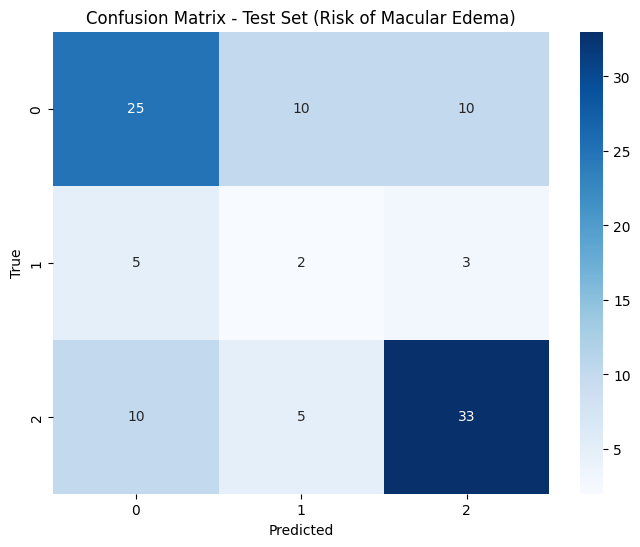

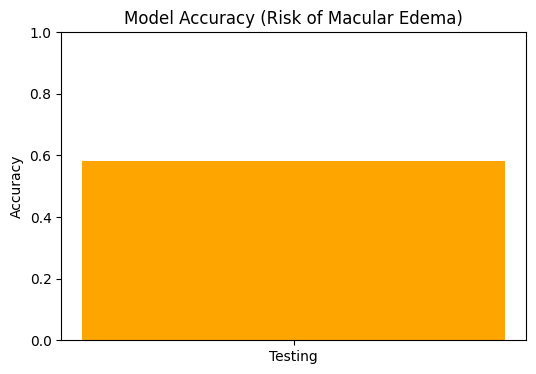

In [21]:
# Predictions for test set
test_pred = np.argmax(model.predict(test_features, verbose=0), axis=1)
test_true = test_labels

# Calculate testing accuracy
test_accuracy = accuracy_score(test_true, test_pred)
print(f'Testing Accuracy: {test_accuracy:.4f}')

# Plot confusion matrix
cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set (Risk of Macular Edema)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('example_plots/confusion_matrix_edema.png')
plt.show()

# Plot testing accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Testing'], [test_accuracy], color='orange')
plt.title('Model Accuracy (Risk of Macular Edema)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.savefig('example_plots/accuracy_bar_edema.png')
plt.show()

Selected Images:
Grade 0: Image=IDRiD_043, Distance=10.00, Exudates=2.842170943040401e-14
Grade 1: Image=IDRiD_094, Distance=4.08, Exudates=10.0
Grade 2: Image=IDRiD_078, Distance=0.86, Exudates=316.0
Debug IDRiD_043:
  Precomputed: Distance=10.00, Exudates=2.842170943040401e-14
  Recalculated: Distance=10.00, Exudates=0
Debug IDRiD_094:
  Precomputed: Distance=4.08, Exudates=10.0
  Recalculated: Distance=4.08, Exudates=10
Debug IDRiD_078:
  Precomputed: Distance=0.86, Exudates=316.0
  Recalculated: Distance=0.86, Exudates=316


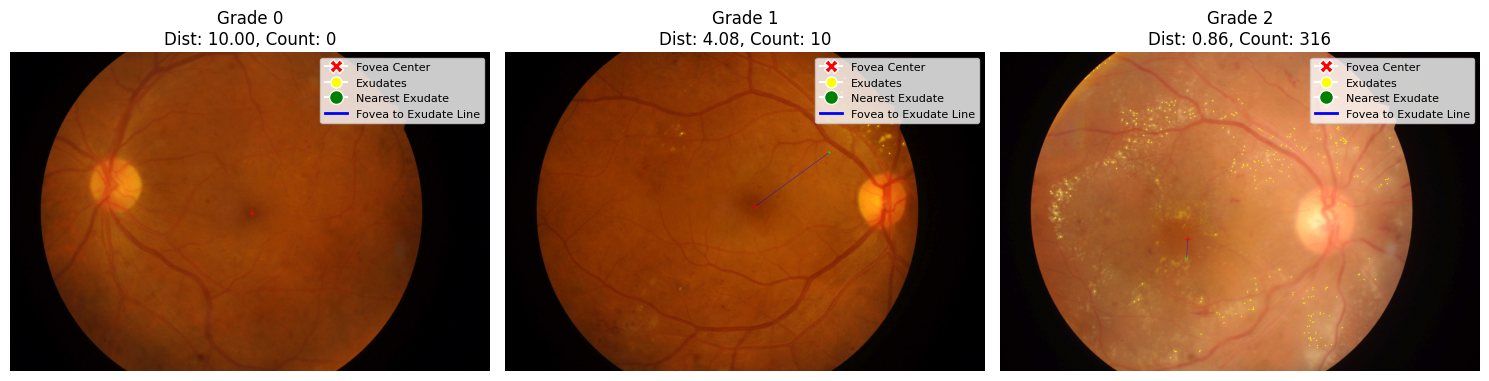

In [27]:
# Denormalize features
train_data['min_distance'] = train_features[:, 0] * train_features_std[0] + train_features_mean[0]
train_data['exudate_count'] = train_features[:, 1] * train_features_std[1] + train_features_mean[1]

# Select specified images
image_names = ['IDRiD_043', 'IDRiD_094', 'IDRiD_078']
selected_images = []
for image_name in image_names:
    image_data = train_data[train_data['image_name'] == image_name]
    if image_data.empty:
        print(f"Warning: Image {image_name} not found in train_data.")
        selected_images.append(pd.DataFrame())
    else:
        selected_images.append(image_data)

# Print selected image details for verification
print("Selected Images:")
for idx, data in enumerate(selected_images):
    if not data.empty:
        row = data.iloc[0]
        print(f"Grade {row['risk_of_macular_edema']}: Image={row['image_name']}, Distance={row['min_distance']:.2f}, Exudates={row['exudate_count']}")

# Define legend elements
legend_elements = [
    Line2D([0], [0], marker='X', color='w', markerfacecolor='red', markersize=10, label='Fovea Center'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Exudates'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Nearest Exudate'),
    Line2D([0], [0], color='blue', lw=2, label='Fovea to Exudate Line')
]

# Visualize
plt.figure(figsize=(15, 5))
for idx, data in enumerate(selected_images):
    if data.empty:
        print(f"No image available for {image_names[idx]}")
        continue
    
    row = data.iloc[0]
    image_name = row['image_name']
    fovea_x = row['fovea_x']
    fovea_y = row['fovea_y']
    precomputed_distance = row['min_distance']
    precomputed_exudates = row['exudate_count']
    image_path = f"C. Localization/1. Original Images/a. Training Set/{image_name}.jpg"
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load {image_path}")
        continue
    
    exudates, _ = detect_exudates(img, image_name, 'segmentation_masks/exudates')
    
    img_copy = img.copy()
    recalculated_distance = 10.0
    nearest_exudate_centroid = None
    for cnt in exudates:
        M = cv2.moments(cnt)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            cv2.circle(img_copy, (cx, cy), 5, (0, 255, 255), -1)
            dist = np.sqrt((cx - fovea_x)**2 + (cy - fovea_y)**2) / 200
            if dist < recalculated_distance:
                recalculated_distance = dist
                nearest_exudate_centroid = (cx, cy)
    
    cv2.drawMarker(img_copy, (int(fovea_x), int(fovea_y)), (0, 0, 255), 
                   markerType=cv2.MARKER_CROSS, markerSize=50, thickness=5)
    if nearest_exudate_centroid:
        cx, cy = nearest_exudate_centroid
        cv2.circle(img_copy, (int(cx), int(cy)), 10, (0, 255, 0), -1)
        cv2.line(img_copy, (int(fovea_x), int(fovea_y)), (int(cx), int(cy)), (255, 0, 0), 2)
    
    print(f"Debug {image_name}:")
    print(f"  Precomputed: Distance={precomputed_distance:.2f}, Exudates={precomputed_exudates}")
    print(f"  Recalculated: Distance={recalculated_distance:.2f}, Exudates={len(exudates)}")
    
    img_rgb = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, idx + 1)
    plt.imshow(img_rgb)
    plt.title(f"Grade {row['risk_of_macular_edema']}\nDist: {precomputed_distance:.2f}, Count: {precomputed_exudates:.0f}")
    plt.axis('off')
    plt.legend(handles=legend_elements, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig('example_plots/disease_grades.png')
plt.show()